Spatial Interpolation Tutorial
Source: https://pygis.io/docs/e_interpolation.html 

In [11]:
# Import modules
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
import rasterio
import rasterio.mask
from rasterio.plot import show
from rasterio.transform import Affine
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import box
from shapely.geometry import Polygon, Point
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

In [12]:
# Load data
# County boundaries
# Source: https://earthworks.stanford.edu/catalog/stanford-jm667wq2232
counties = gpd.read_file("data/cacounties.json")

# Depth to Groundwater Spring 2012 
# Source: https://earthworks.stanford.edu/catalog/stanford-pp561fb8417

groundwater = gpd.read_file("data/stanfordgroundwater2012.json")

# Reproject data to CA Teale Albert
# https://nrm.dfg.ca.gov/FileHandler.ashx?DocumentID=109326&inline
proj = "+proj=aea +lat_1=34 +lat_2=40.5 +lat_0=0 +lon_0=-120 +x_0=0 +y_0=-4000000 +ellps=GRS80 +datum=NAD83 +units=m +no_defs "
counties = counties.to_crs(proj)
groundwater = groundwater.to_crs(proj)

In [14]:
counties

,id,NAME_PCASE,NAME_UCASE,FMNAME_PC,FMNAME_UC,ABBREV,NUM,ABCODE,FIPS,ANSI,ISLAND,Shape_Leng,Shape_Area,geometry
0,s73w23.1,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,N,306175.156646,2.625847e+09,"MULTIPOLYGON (((-346163.263 440231.265, -34619..."
1,s73w23.2,Siskiyou,SISKIYOU,Siskiyou County,SISKIYOU COUNTY,SIS,47,c047,093,093,N,672205.907573,1.643940e+10,"MULTIPOLYGON (((-291951.565 447930.560, -29057..."
2,s73w23.3,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,Y,544.475439,1.408669e+04,"MULTIPOLYGON (((-349771.330 445307.502, -34978..."
3,s73w23.4,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,Y,1382.224853,7.044746e+04,"MULTIPOLYGON (((-350041.637 444649.968, -35004..."
4,s73w23.5,Del Norte,DEL NORTE,Del Norte County,DEL NORTE COUNTY,DEL,8,c008,015,015,Y,3659.554577,2.560796e+05,"MULTIPOLYGON (((-348941.861 442590.794, -34895..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,s73w23.175,San Diego,SAN DIEGO,San Diego County,SAN DIEGO COUNTY,SDG,37,c037,073,073,Y,3564.003182,5.099051e+05,"MULTIPOLYGON (((258977.992 -578627.459, 258954..."
175,s73w23.176,San Diego,SAN DIEGO,San Diego County,SAN DIEGO COUNTY,SDG,37,c037,073,073,Y,670.833807,1.819247e+04,"MULTIPOLYGON (((261474.200 -578284.264, 261454..."
176,s73w23.177,San Diego,SAN DIEGO,San Diego County,SAN DIEGO COUNTY,SDG,37,c037,073,073,Y,3206.078394,1.149488e+05,"MULTIPOLYGON (((269245.883 -594401.754, 269221..."
177,s73w23.178,San Diego,SAN DIEGO,San Diego County,SAN DIEGO COUNTY,SDG,37,c037,073,073,Y,794.501888,2.948134e+04,"MULTIPOLYGON (((269656.197 -594469.690, 269651..."


In [13]:
groundwater

,id,site_code,local_well,state_well,wcr_number,well_use,msmt_date,msmt_agenc,wsel,dgbs,rp_elevati,gs_elevati,msmt_metho,msmt_issue,msmt_comme,latitude,longitude,link_to_wd,geometry
0,pp561fb8417.1,364921N1198721W001,16S19E35Q001M,16S19E35Q001M,NaN,6.0,2012-02-01,1.0,51.92,175.8,229.32,227.72,7.0,0.0,NaN,36.492100,-119.872100,http://www.water.ca.gov/waterdatalibrary/groun...,POINT (11441.501 -169425.679)
1,pp561fb8417.2,367706N1204502W001,13S/14E-28L01,13S14E28L001M,24016,3.0,2012-04-20,5100.0,140.00,58.0,198.00,198.00,3.0,0.0,NaN,36.770744,-120.450111,http://www.water.ca.gov/waterdatalibrary/groun...,POINT (-40123.593 -138368.607)
2,pp561fb8417.3,366617N1204060W001,14S/14E-36N03,14S14E36N003M,NaN,3.0,2012-04-23,5100.0,45.00,161.0,206.00,206.00,3.0,0.0,NaN,36.661983,-120.405875,http://www.water.ca.gov/waterdatalibrary/groun...,POINT (-36232.244 -150474.419)
3,pp561fb8417.4,366611N1204238W001,15S/14E-02D04,15S14E02D004M,384237,3.0,2012-04-23,5100.0,151.00,70.0,221.00,221.00,3.0,0.0,NaN,36.661375,-120.423942,http://www.water.ca.gov/waterdatalibrary/groun...,POINT (-37845.316 -150534.933)
4,pp561fb8417.5,366422N1204604W001,15S/14E-09E03,15S14E09E003M,480134,3.0,2012-04-23,5100.0,136.00,119.0,255.00,255.00,3.0,0.0,NaN,36.642067,-120.460044,http://www.water.ca.gov/waterdatalibrary/groun...,POINT (-41078.440 -152665.796)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4803,pp561fb8417.4804,385209N1219646W001,08N01W22P001M,08N01W22P001M,NaN,4.0,2012-03-26,624.0,81.30,50.3,132.30,131.60,7.0,0.0,NaN,38.520900,-121.964500,http://www.water.ca.gov/waterdatalibrary/groun...,POINT (-171072.028 57858.902)
4804,pp561fb8417.4805,385246N1219032W001,08N01E19K001M,08N01E19K001M,NaN,3.0,2012-03-26,624.0,66.58,40.0,107.08,106.58,7.0,0.0,NaN,38.525400,-121.903500,http://www.water.ca.gov/waterdatalibrary/groun...,POINT (-165750.708 58250.641)
4805,pp561fb8417.4806,385161N1219202W001,08N01W25A002M,08N01W25A002M,NaN,3.0,2012-03-26,624.0,71.88,44.7,117.08,116.58,7.0,0.0,NaN,38.515700,-121.917400,http://www.water.ca.gov/waterdatalibrary/groun...,POINT (-166982.727 57197.010)
4806,pp561fb8417.4807,375007N1211816W001,NaN,05S07E15G001M,NaN,6.0,2012-04-02,624.0,41.67,110.8,153.47,152.47,7.0,0.0,NaN,37.500700,-121.181600,http://www.water.ca.gov/waterdatalibrary/groun...,POINT (-104314.088 -56674.073)


In [15]:
# Get X and Y coordinates of rainfall points
x_water = groundwater["geometry"].x
y_water = groundwater["geometry"].y

# Create list of XY coordinate pairs
coords_rain = [list(xy) for xy in zip(x_water, y_water)]

# Get extent of counties feature
min_x_counties, min_y_counties, max_x_counties, max_y_counties = counties.total_bounds

# Get list of rainfall "values"
value_water = list(groundwater["dgbs"])

# Create a copy of counties dataset
counties_dissolved = counties.copy()

# Add a field with constant value of 1
counties_dissolved["constant"] = 1

# Dissolve all counties to create one polygon
counties_dissolved = counties_dissolved.dissolve(by = "constant").reset_index(drop = True)

In [17]:
def export_kde_raster(Z, XX, YY, min_x, max_x, min_y, max_y, proj, filename):
    '''Export and save a kernel density raster.'''

    # Get resolution
    xres = (max_x - min_x) / len(XX)
    yres = (max_y - min_y) / len(YY)

    # Set transform
    transform = Affine.translation(min_x - xres / 2, min_y - yres / 2) * Affine.scale(xres, yres)

    # Export array as raster
    with rasterio.open(
            filename,
            mode = "w",
            driver = "GTiff",
            height = Z.shape[0],
            width = Z.shape[1],
            count = 1,
            dtype = Z.dtype,
            crs = proj,
            transform = transform,
    ) as new_dataset:
            new_dataset.write(Z, 1)

In [19]:
# Split data into testing and training sets
coords_rain_train, coords_rain_test, value_rain_train, value_rain_test = train_test_split(coords_rain, value_water, test_size = 0.20, random_state = 42)

# Create separate GeoDataFrames for testing and training sets
rain_train_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_train], crs = proj)
rain_train_gdf["Actual_Value"] = value_rain_train
rain_test_gdf = gpd.GeoDataFrame(geometry = [Point(x, y) for x, y in coords_rain_test], crs = proj)
rain_test_gdf["Actual_Value"] = value_rain_test

# Get minimum and maximum coordinate values of rainfall training points
min_x_rain, min_y_rain, max_x_rain, max_y_rain = rain_train_gdf.total_bounds

Text(0.5, 1.0, 'San Francisco Bay Area - Groundwater Measurement Locations')

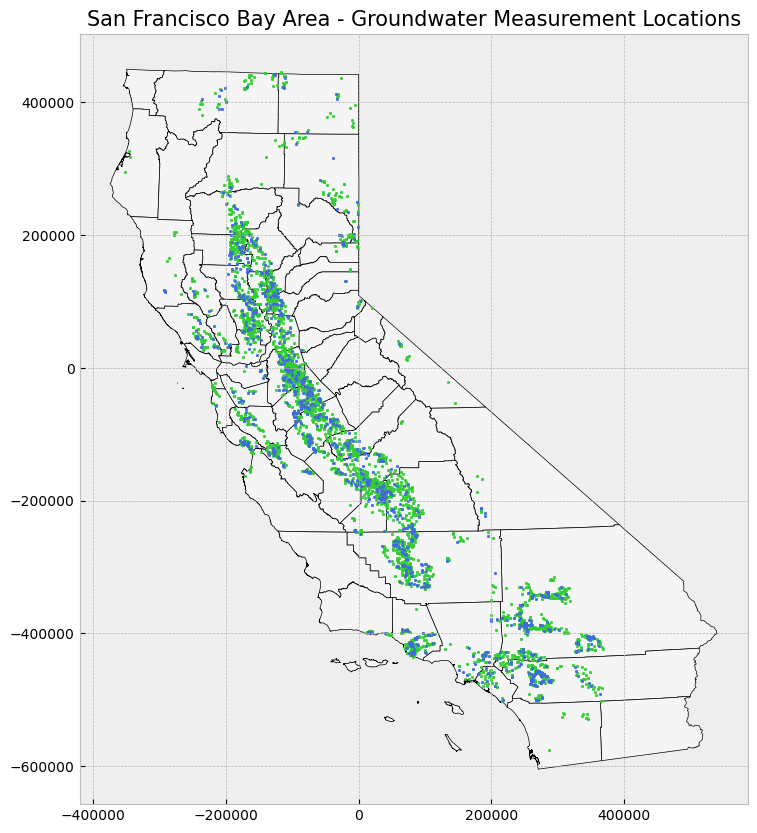

In [21]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

# Stylize plots
plt.style.use('bmh')

# Plot data
counties.plot(ax = ax, color = 'whitesmoke', edgecolor = 'black')
rain_train_gdf.plot(ax = ax, marker = 'o', color = 'limegreen', markersize = 3)
rain_test_gdf.plot(ax = ax, marker = 'o', color = 'royalblue', markersize = 3)
# Set title
ax.set_title('San Francisco Bay Area - Groundwater Measurement Locations', fontdict = {'fontsize': '15', 'fontweight' : '3'})